### Листинг 2.1. Поиск профиля штрих-кода вдоль оси Ox.

**Профиль изображения**

Профилем изображения вдоль некоторой линии называется функция интенсивности изображения, 
распределенного вдоль данной линии (прорезки). Простейшим случаем профиля изображения является профиль строки:

Profile 𝑖(𝑥) = 𝐼(𝑥,𝑖), (1.8)

где 𝑖 — номер строки изображения 𝐼.

Профиль столбца изображения:

Profile 𝑗(𝑦) = 𝐼(𝑗,𝑦), (1.9)

где 𝑗 — номер столбца изображения 𝐼.

В общем случае профиль можно рассматривать вдоль любой прямой, ломаной или кривой линии, пересекающей изображение.
После формирования массива профиля изображения проводится его анализ стандартными средствами. 
Анализ позволяет автоматически выделять особые точки функции профиля, соответствующие контурам изображения, 
пересекаемым данной линией.

In [1]:
import cv2
import numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from numba import njit, jit
from math import *
import imutils
import warnings
from scipy.signal import find_peaks
warnings.filterwarnings('ignore')
export_parallel = True
use_graph = True

In [2]:
# Считаю обычный штрих код в чёрно-белом формате.
image = cv2.cvtColor(cv2.imread("data/barcode.png"), cv2.COLOR_BGR2GRAY)

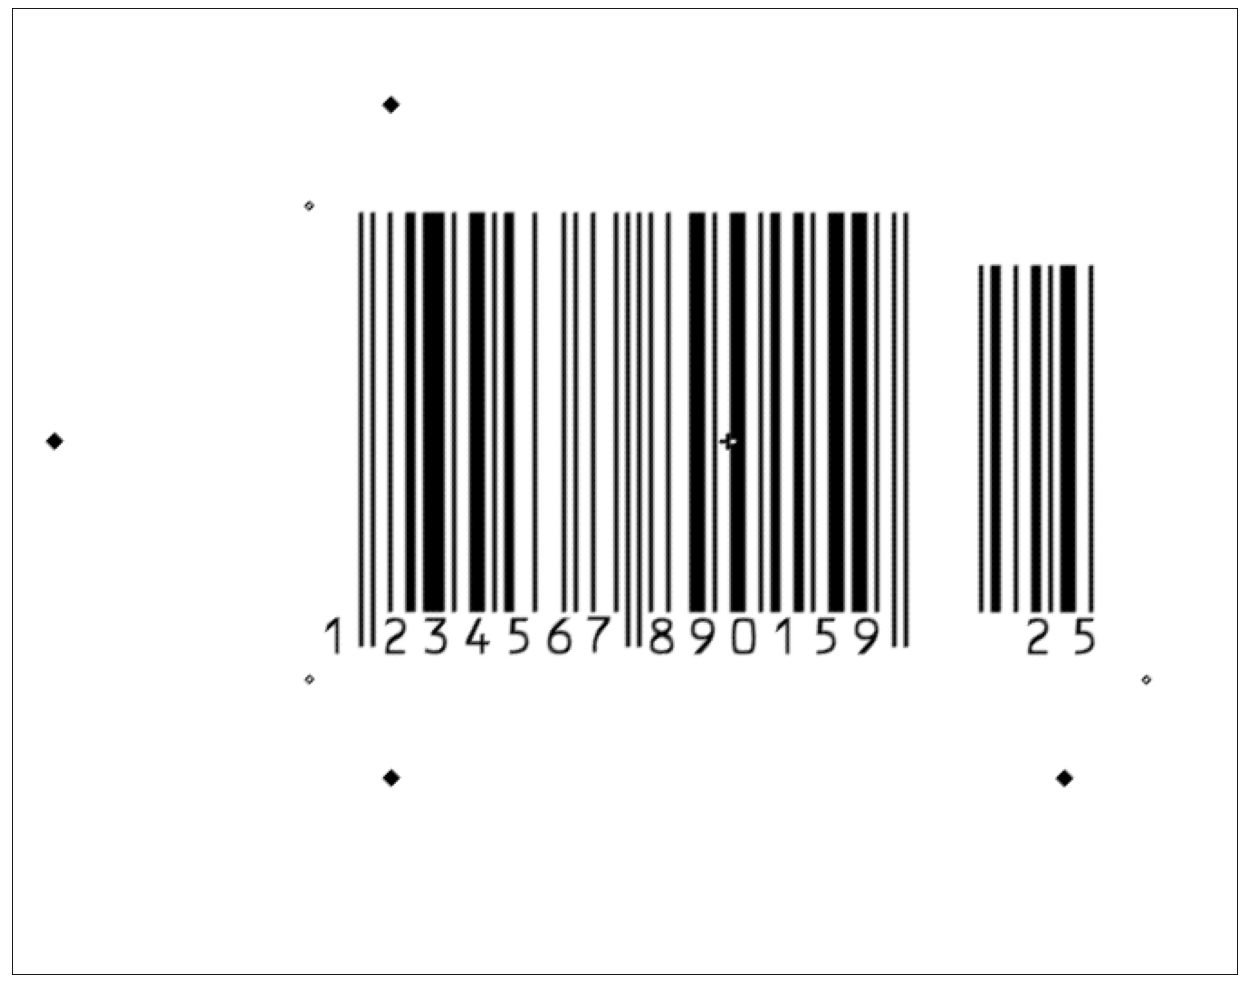

In [3]:
# Обычный штрих код
if use_graph:
    figure(figsize=(32, 16), dpi=80)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

In [4]:
# Для вычисления профиля буквально посчитаю интенсивности вдоль одной центральной линии.
@njit(parallel=export_parallel)
def improfile(image, profile_line_raw=None, profile_length=None):
    if profile_line_raw is None:
        profile_line = np.array([image.shape[0] / 2.0, 0.0, image.shape[0] / 2.0, 1.0 * image.shape[1]], dtype="float64")
    else:
        profile_line = np.array(profile_line_raw, dtype="float64")
    if profile_length is None:
        profile_length = sqrt(pow(profile_line[2] - profile_line[0], 2.0) + pow(profile_line[3] - profile_line[1], 2.0))
    image -= np.min(image)
    max_intensity = np.max(image)
    intensity = np.zeros((ceil(profile_length), ))
    initial_point = profile_line[0:2]
    vector = (profile_line[2:4] - initial_point)
    for t in range(ceil(profile_length)):
        current_point = initial_point + vector * (1.0 * t / profile_length)
        if current_point[0] > image.shape[0] - 1 or current_point[1] > image.shape[1] - 1 or current_point[0] < 0 or current_point[1] < 0:
            continue
        for x in range(floor(current_point[1]), floor(current_point[1]) + 2):
            for y in range(floor(current_point[0]), floor(current_point[0]) + 2):
                multiplier = (1 - abs(x - current_point[1])) * (1 - abs(y - current_point[0]))
                intensity[t] += (max_intensity - image[y][x]) * multiplier
    return intensity

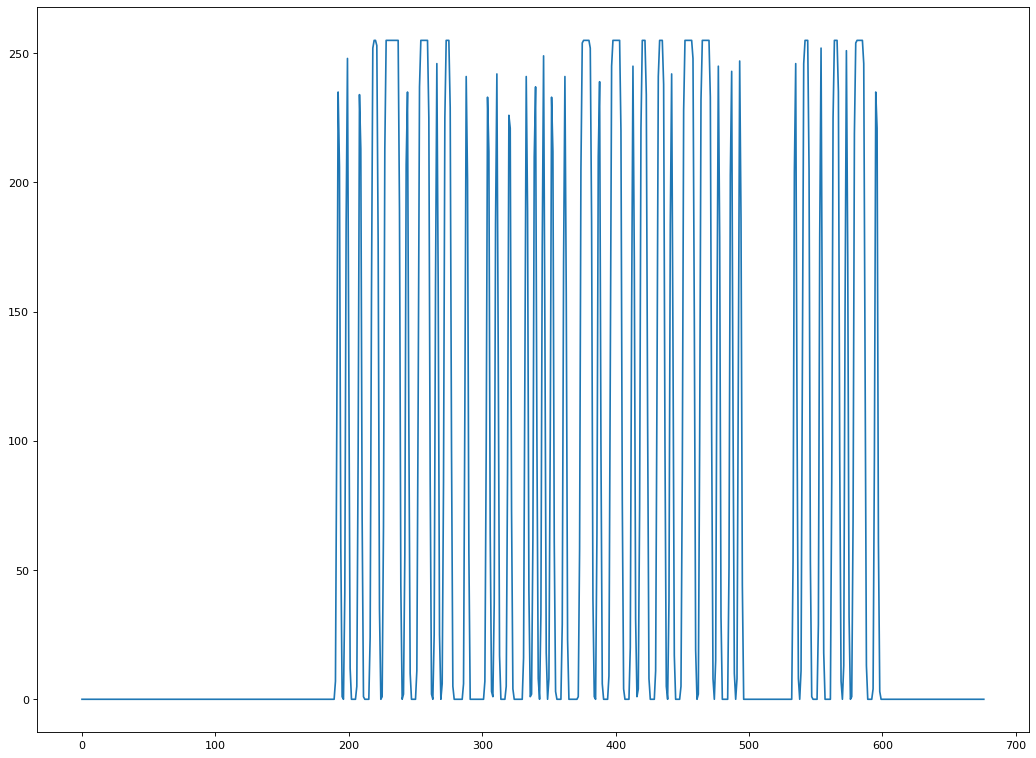

In [5]:
# Выведу профиль изображения вдоль центральной линии.
if use_graph:
    figure(figsize=(16, 12), dpi=80)
    plt.plot(improfile(image))

Полученные данные можно использовать для считывания самого штрих кода, 
но пока что сам считыватель получается не очень умным, так как не реагирует на повороты.

### Листинг 2.2. Интерактивное задание линии профиля.

In [6]:
# Считаю повёрнутый штрих код в чёрно-белом формате.
image = cv2.cvtColor(cv2.imread("data/barcode_rotation.png"), cv2.COLOR_BGR2GRAY)

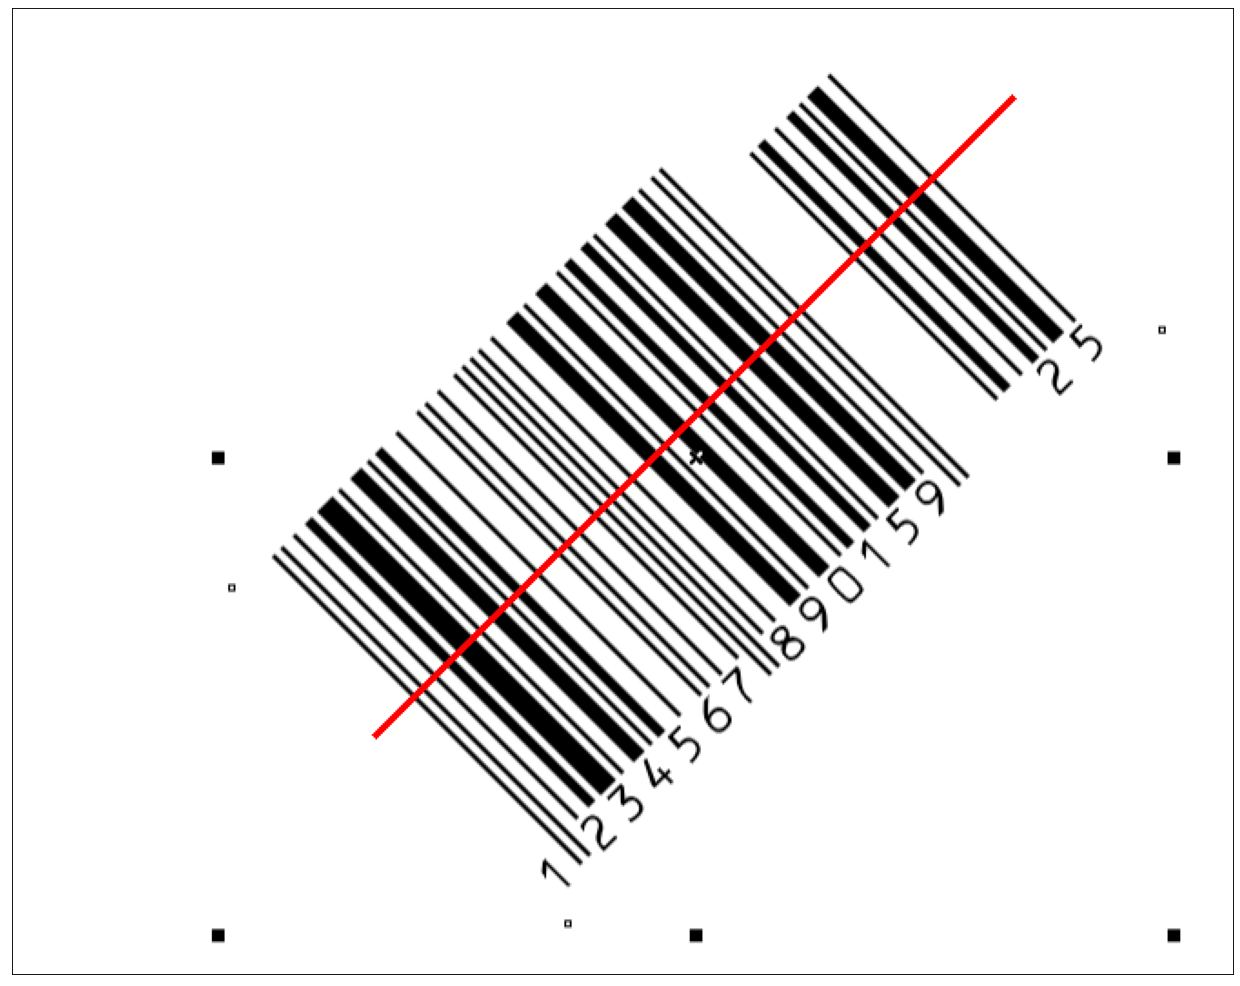

In [7]:
# Интерактивное задание линии профиля.
line = [400, 200, 50, 550] # y0, x0, y1, x1

# Повёрнутый штрих код
if use_graph:
    figure(figsize=(32, 16), dpi=80)
    image_draw = cv2.imread("data/barcode_rotation.png")
    line_draw = line[::-1]
    image_draw = cv2.line(image_draw, tuple(line_draw[0:2]), tuple(line_draw[2:4]), color=(0, 0, 255), thickness=3)
    plt.imshow(cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

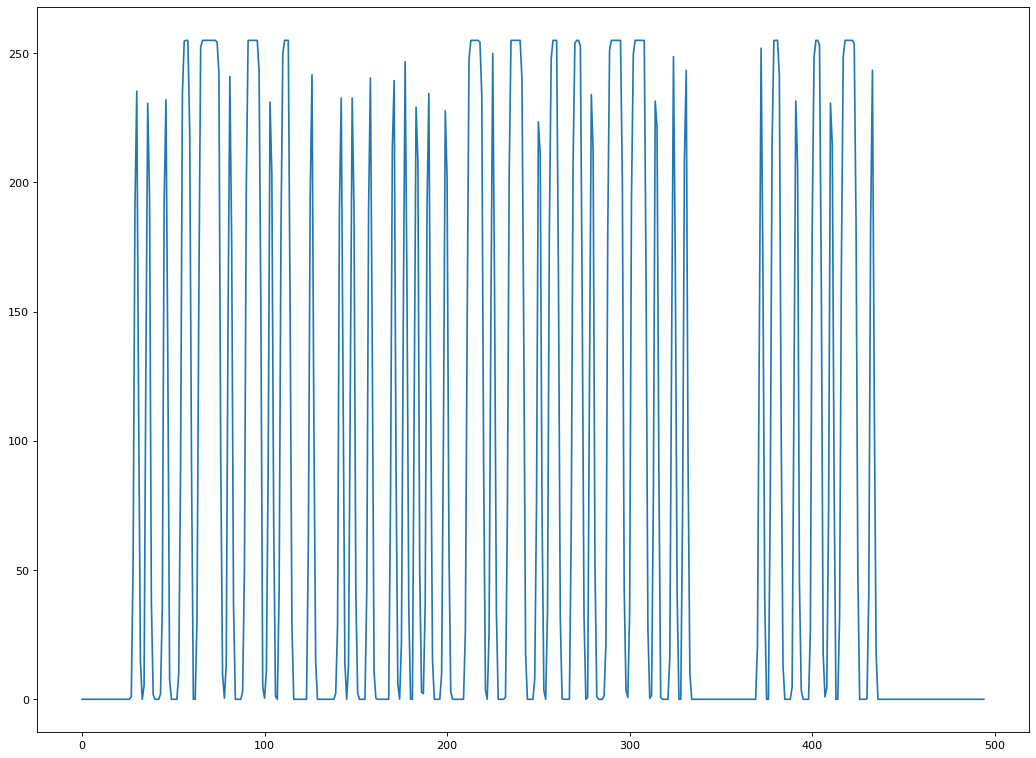

In [8]:
# Выведу повёрнутый профиль изображения вдоль заданной линии.
if use_graph:
    figure(figsize=(16, 12), dpi=80)
    plt.plot(improfile(image, line))

Можно считывать штрих код даже в повернутом виде. 
Если вычислить местоположение штрих кода на изображении, можно даже автоматизировать этот процесс.

### Листинг 2.3. Определение положения текста

**Проекция изображения**

Проекцией изображения на некоторую ось называется суммаинтенсивностей пикселей изображения в направлении, 
перпендикулярном данной оси. 

Простейшим случаем проекции двумерного изображения являются вертикальная проекция 
на ось 𝑂𝑥, представляющая собой сумму интенсивностей пикселей по столбцам изображения:

Proj 𝑋(x) = sum(𝐼(𝑥,𝑦) for y in range (0, len(𝑌)))

и горизонтальная проекция на ось 𝑂𝑦, представляющая собой сумму интенсивностей пикселей по строкам изображения:

Proj Y(y) = sum(𝐼(𝑥,𝑦) for x in range (0, len(X)))

Запишем выражение для проекции на произвольную ось. 
Допустим, что направление оси задано единичным вектором с координатами (𝑒𝑥,𝑒𝑦). 
Тогда проекция изображения на ось 𝑂𝑒 определяется следующим выражением:

Proj E(t) = sum(𝐼(𝑥,𝑦) for all i where x = ex * t + ey * i + and y = ey * t + ex * i)

Анализ массива проекции позволяет выделять характерные точки функции проекции, которые соответствуют контурам объектов
на изображении. Например, если на изображении имеются контрастные объекты, то в проекции будут видны перепады или 
экстремумы функции, соответствующие положению каждого из объектов.

Подобные проекции могут быть использованы в алгоритмах обнаружения и сегментации текстовых строк в 
системах распознавания текста.

In [9]:
def calc_projection_X(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (thresh, image) = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    image -= np.min(image)
    max_intensity = np.max(image)
    vertical_pixel_sum = np.sum(max_intensity - image, axis=0)
    return vertical_pixel_sum

def calc_angle_projection(image, angle):
    image = 255 - image
    image_rotated = imutils.rotate_bound(image, angle)
    image_rotated = 255 - image_rotated
    return calc_projection_X(image_rotated)

In [10]:
# Считаю текст
image = cv2.imread("data/text_skew_inputs.png")

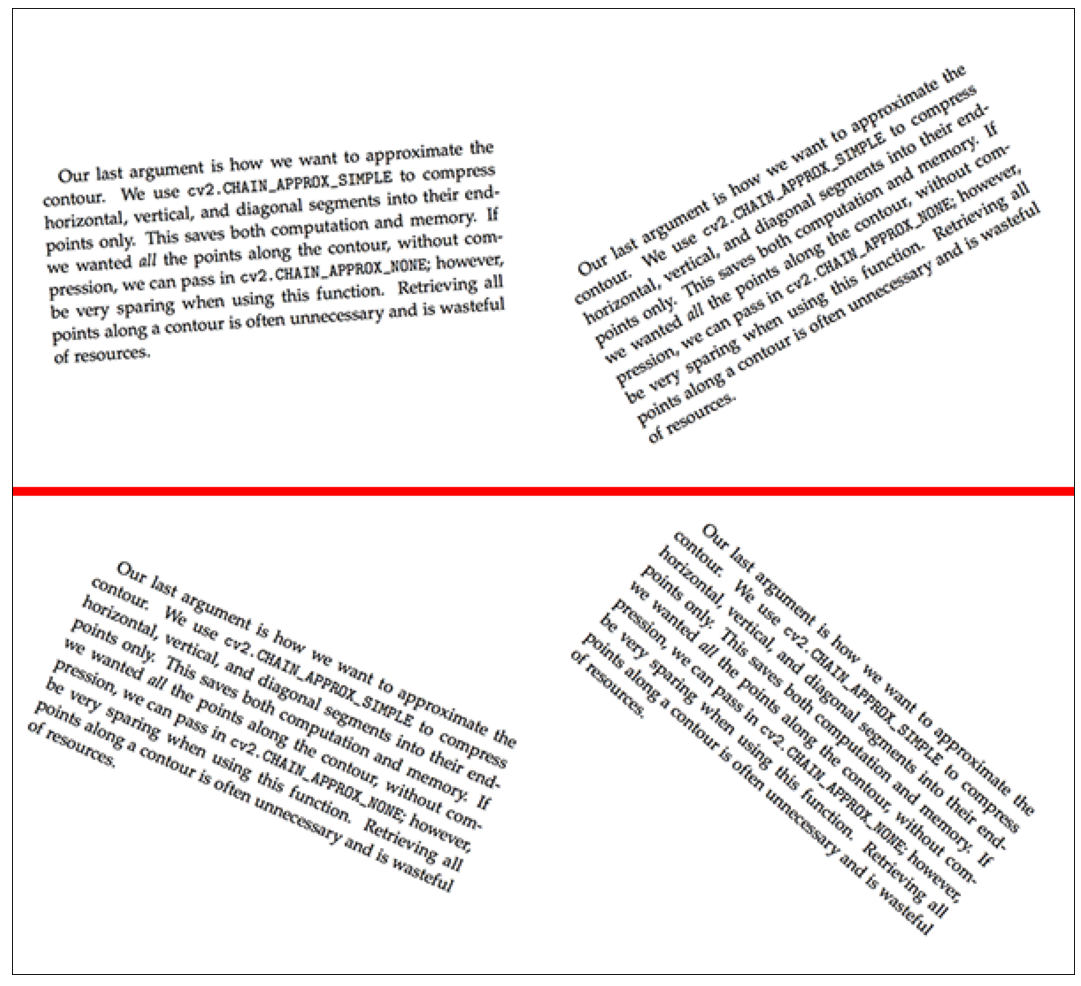

In [11]:
# Вычислю проекцию на ось Ox
angle_max = 0
if use_graph:
    figure(figsize=(32, 16), dpi=80)
    image_draw = image.copy()
    line_len = norm(np.array(image.shape)) / 2.0
    line = [image.shape[1] / 2.0 - cos(angle_max * pi / 180) * line_len,
            image.shape[0] / 2.0 - sin(-angle_max * pi / 180) * line_len, 
            image.shape[1] / 2.0 + cos(angle_max * pi / 180) * line_len,
            image.shape[0] / 2.0 + sin(-angle_max * pi / 180) * line_len]
    line = np.array(line, dtype="int64")
    image_draw = cv2.line(image_draw, tuple(line[0:2]), tuple(line[2:4]), color=(0, 0, 255), thickness=3)
    plt.imshow(cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

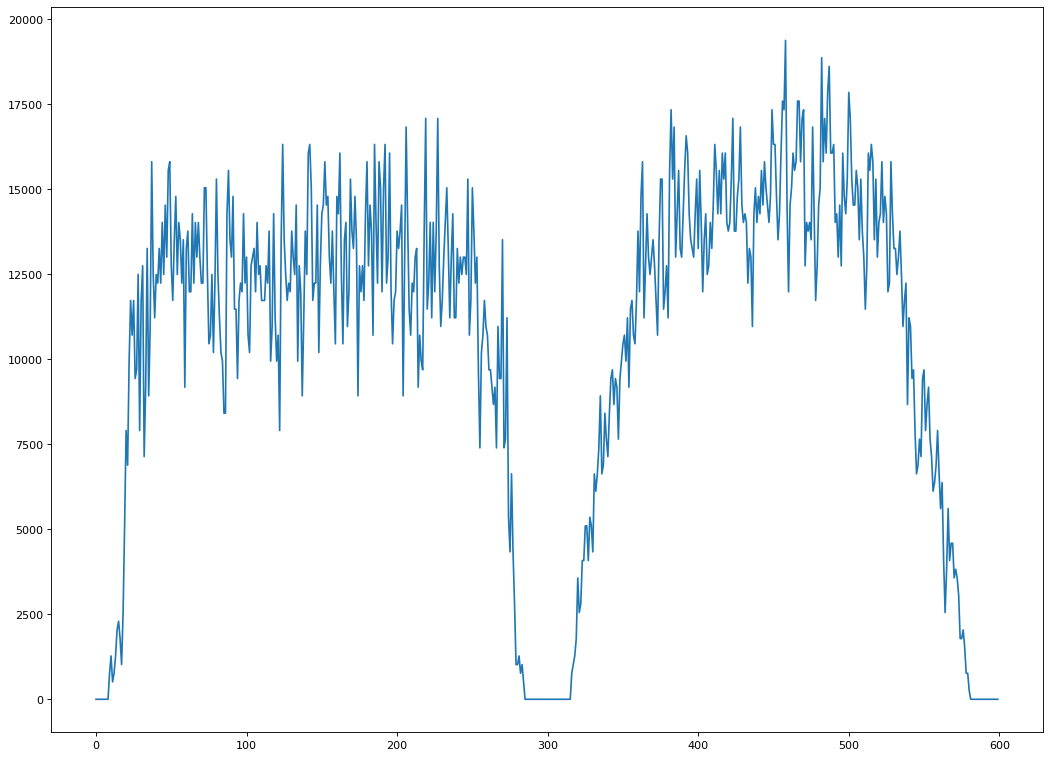

In [12]:
if use_graph:
    figure(figsize=(16, 12), dpi=80)
    plt.plot(calc_angle_projection(image, angle_max))

In [13]:
# Считаю текст
image = cv2.imread("data/text_skew_inputs.png")

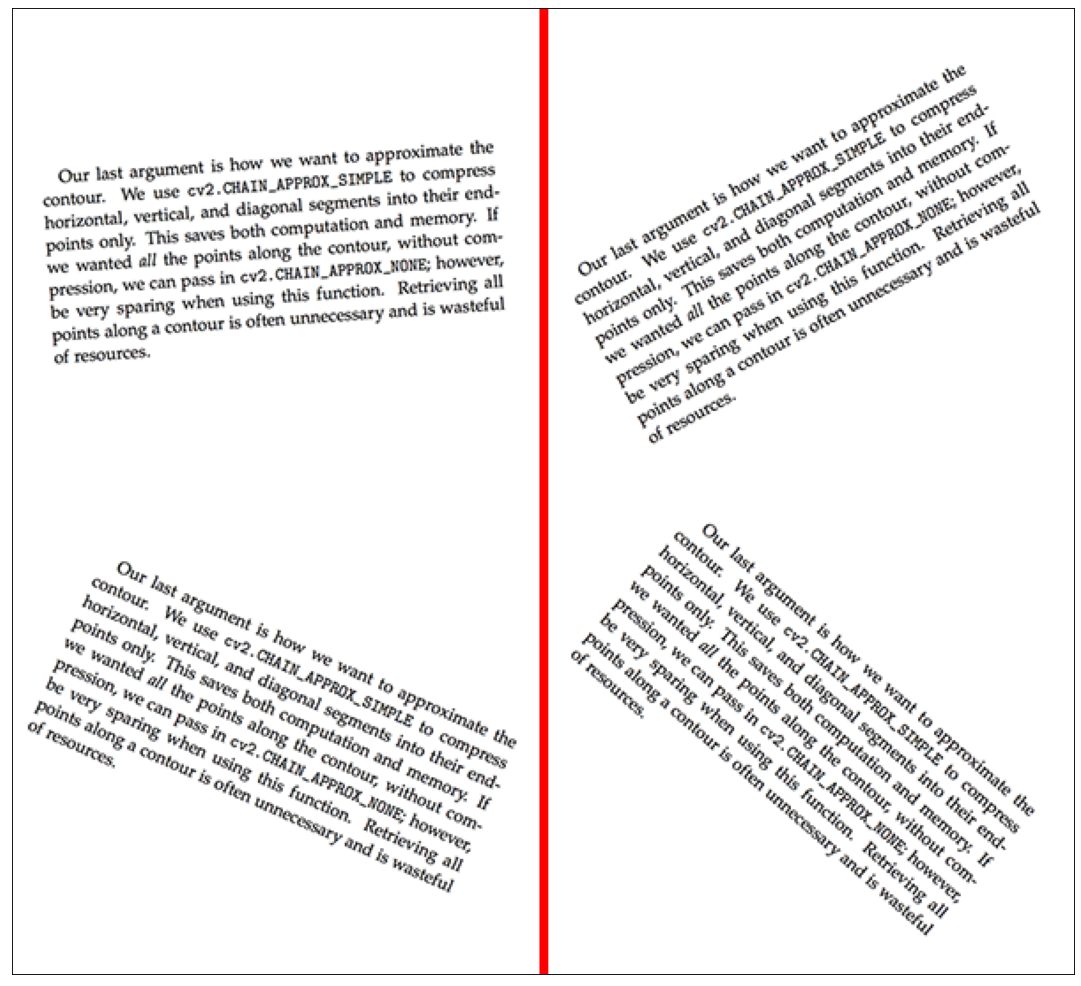

In [14]:
# Вычислю проекцию на ось Oy
angle_max = 90
if use_graph:
    figure(figsize=(32, 16), dpi=80)
    image_draw = image.copy()
    line_len = norm(np.array(image.shape)) / 2.0
    line = [image.shape[1] / 2.0 - cos(angle_max * pi / 180) * line_len,
            image.shape[0] / 2.0 - sin(-angle_max * pi / 180) * line_len, 
            image.shape[1] / 2.0 + cos(angle_max * pi / 180) * line_len,
            image.shape[0] / 2.0 + sin(-angle_max * pi / 180) * line_len]
    line = np.array(line, dtype="int64")
    image_draw = cv2.line(image_draw, tuple(line[0:2]), tuple(line[2:4]), color=(0, 0, 255), thickness=3)
    plt.imshow(cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

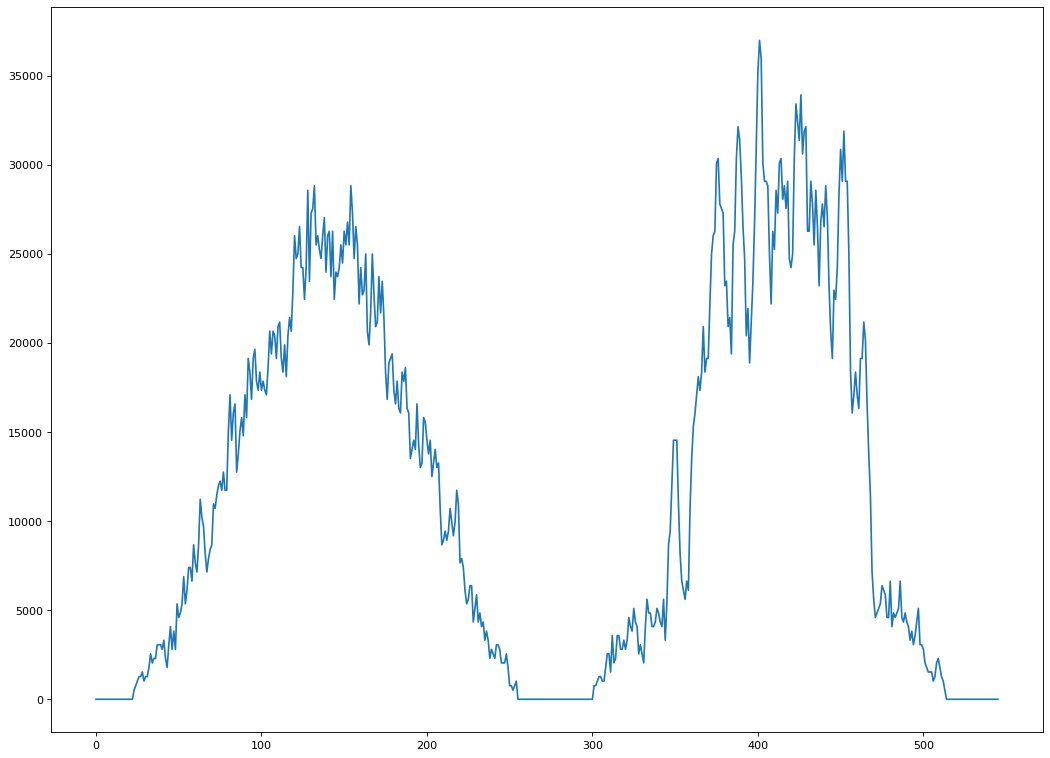

In [15]:
if use_graph:
    figure(figsize=(16, 12), dpi=80)
    plt.plot(calc_angle_projection(image, angle_max))

Из преокции можно сделать вывод, что текста 4, и они находятся по 4 стороны от изображения. 

In [16]:
# Считаю повёрнутый текст
image = cv2.imread("data/rotatedtext.jpg")

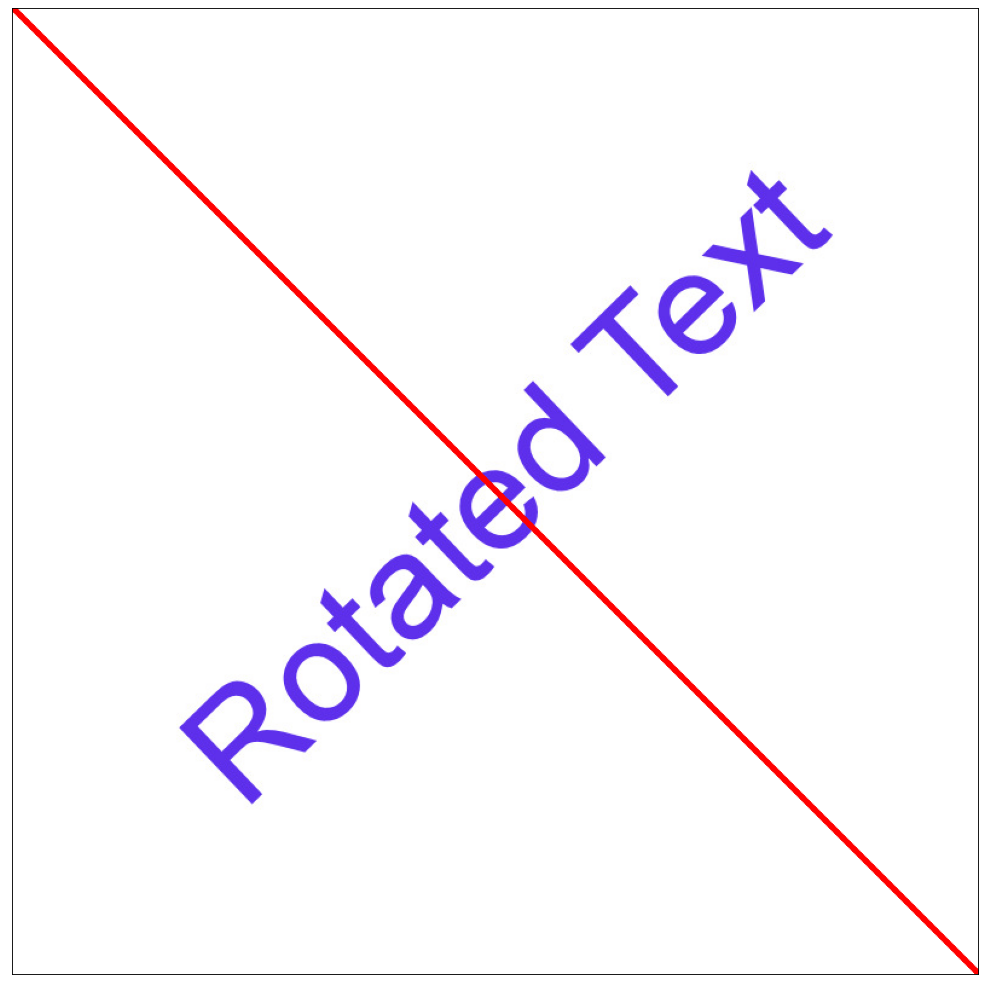

In [17]:
# Вычислю проекцию на ось, перпендикулярную оси текста
angle_max = -45
if use_graph:
    figure(figsize=(32, 16), dpi=80)
    image_draw = image.copy()
    line_len = norm(np.array(image.shape)) / 2.0
    line = [image.shape[1] / 2.0 - cos(angle_max * pi / 180) * line_len,
            image.shape[0] / 2.0 - sin(-angle_max * pi / 180) * line_len, 
            image.shape[1] / 2.0 + cos(angle_max * pi / 180) * line_len,
            image.shape[0] / 2.0 + sin(-angle_max * pi / 180) * line_len]
    line = np.array(line, dtype="int64")
    image_draw = cv2.line(image_draw, tuple(line[0:2]), tuple(line[2:4]), color=(0, 0, 255), thickness=3)
    plt.imshow(cv2.cvtColor(image_draw, cv2.COLOR_BGR2RGB))
    plt.xticks([]),plt.yticks([])
    plt.show()

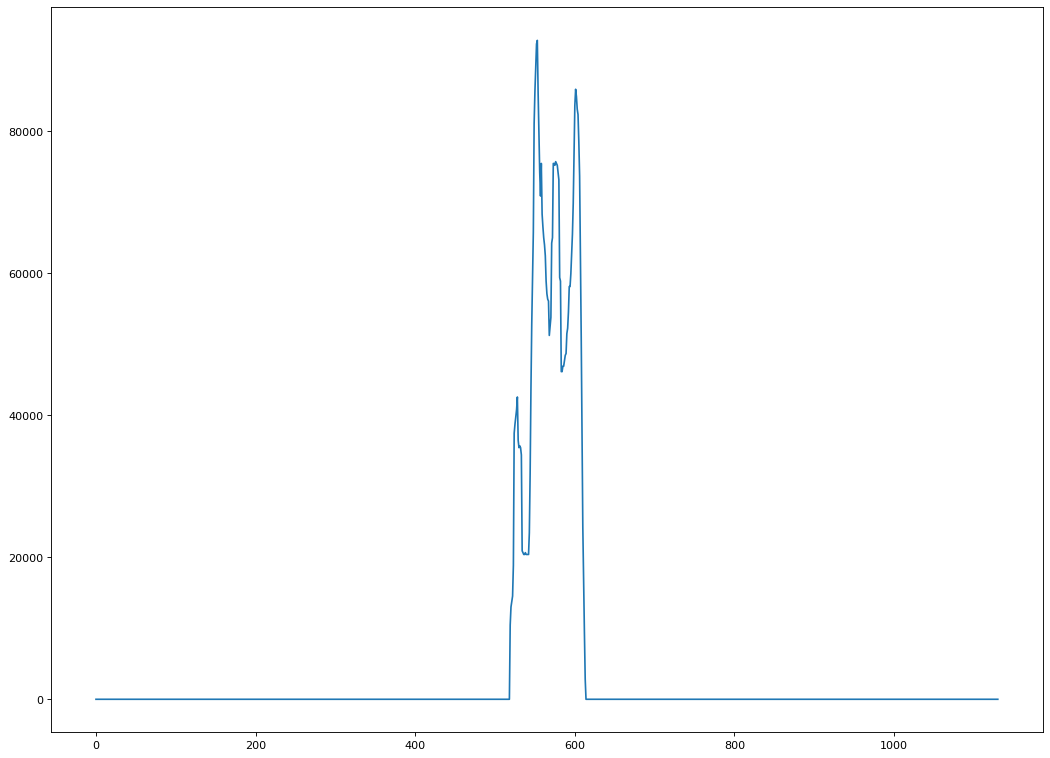

In [18]:
if use_graph:
    figure(figsize=(16, 12), dpi=80)
    plt.plot(calc_angle_projection(image, angle_max))

По единичному пику можно сделать вывод о местоположении текста.
